## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import tikzplotlib

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_predict, validation_curve, learning_curve

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.compose import TransformedTargetRegressor
from sklearn.feature_selection import mutual_info_regression

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer, r2_score

from utils.preprocessing import preprocess_duplicated_and_missing, preprocess_irrelevant_features, one_hot_encode_genres_feature, one_hot_encode_studio_feature, remove_outliers, other_fixes, standardize
from utils.feature_extraction import extract_embeddings_features, pca_on_embeddings
from utils.feature_selection import get_mutual_information_matrix, normalize_mutual_information_matrix, select_features_MI_kbest, mrmr, select_features_RFECV
from utils.model_selection import linreg, perform_grid_search, perform_random_search, ModelSelection
from utils.plots import plot_correlation_matrix, plot_mutual_information_matrix, plot_mutual_information_with_target

In [2]:
# declare variables for model selection
N_SPLITS = 5

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
rmse = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

In [3]:
pd.set_option('display.max_columns', 50)

## Load datasets

In [4]:
def read_datasets():
	X1 = pd.read_csv("datasets/X1.csv", na_values="\\N")
	Y1 = pd.read_csv("datasets/Y1.csv", header=None, names=["revenues"])
	X2 = pd.read_csv("datasets/X2.csv", na_values="\\N")

	X1.drop("Unnamed: 0", axis=1, inplace=True)
	X2.drop("Unnamed: 0", axis=1, inplace=True)
	df = pd.concat([X1, Y1], axis = 1)

	print(f"X1 dataset contains {X1.shape[0]} observations and {X1.shape[1]} features")
	print(f"X2 dataset (for prediction only) contains {X2.shape[0]} observations")

	return df, X2

## Preprocessing

In [5]:
def preprocess(df, train, X2, dataset_name):
	print("-" * 25)
	print(f"PREPROCESSING {dataset_name}...")
	print("-" * 25)
	# remove duplicated observations and preprocessing missing values
	df = preprocess_duplicated_and_missing(df, train)
	X2 = preprocess_duplicated_and_missing(X2, train)

	# remove (obvious) irrelevant/redundant features
	df = preprocess_irrelevant_features(df)
	X2 = preprocess_irrelevant_features(X2)

	# fix high-cardinality + one-hot-encode studio feature
	df, X2 = one_hot_encode_studio_feature(df, X2)

	# one-hot encode genres feature
	df, X2 = one_hot_encode_genres_feature(df, X2)

	# minor fixes
	df = other_fixes(df)
	X2 = other_fixes(X2)
	return df, X2

## Feature extraction and dimension reduction

In [6]:
def remove_outliers_and_split(X, Y):
	print("-" * 25)
	print("REMOVING OUTLIERS AND TRAIN-TEST SPLIT...")
	print("-" * 25)

	X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8, test_size = 0.2, shuffle = True, random_state = 0)

	print(f"training dataset dimension: X_train: {X_train.shape}, y_train: {y_train.shape}")
	print(f"testing dataset dimension: X_test: {X_test.shape}, y_test: {y_test.shape}")

	# remove outliers only on train set
	# as test set should be representative of the reality
	X_train, y_train = remove_outliers(X_train, y_train, ["runtime", "production_year", "release_year"])

	return X_train, y_train, X_test, y_test

def extract_features(X_train, y_train, X_test, y_test, X2, run_pca=True, non_linear=True):
	print("-" * 25)
	print("FEATURE EXTRACTION...")
	print("-" * 25)

	# extract feature vectors
	X_train_img_embeddings = extract_embeddings_features(X_train["img_embeddings"])
	X_test_img_embeddings = extract_embeddings_features(X_test["img_embeddings"])

	X_train_text_embeddings = extract_embeddings_features(X_train["text_embeddings"])
	X_test_text_embeddings = extract_embeddings_features(X_test["text_embeddings"])

	# should also extract features for X2
	X2_img_embeddings = extract_embeddings_features(X2["img_embeddings"])
	X2_text_embeddings = extract_embeddings_features(X2["text_embeddings"])

	X_train_img_df, X_test_img_df, X2_img_df = pca_on_embeddings(X_train_img_embeddings, X_test_img_embeddings, X2_img_embeddings, X_train.index, X_test.index, X2.index, prefix="img_feature", total_variance_explained=5, run_pca=run_pca, non_linear=non_linear)

	X_train_text_df, X_test_text_df, X2_text_df = pca_on_embeddings(X_train_text_embeddings, X_test_text_embeddings, X2_text_embeddings, X_train.index, X_test.index, X2.index, prefix="text_feature", total_variance_explained=5, run_pca=run_pca, non_linear=non_linear)

	# drop unnecessary features
	X_train.drop(["img_embeddings", "text_embeddings"], axis=1, inplace=True)
	X_test.drop(["img_embeddings", "text_embeddings"], axis=1, inplace=True)
	X2.drop(["img_embeddings", "text_embeddings"], axis=1, inplace=True)

	# standardize other features
	X_train, X_test, X2, standard_scaler = standardize(X_train, X_test, X2)

	X_train = pd.concat([X_train, X_train_img_df, X_train_text_df], axis=1)
	X_test = pd.concat([X_test, X_test_img_df, X_test_text_df], axis=1)
	X2 = pd.concat([X2, X2_img_df, X2_text_df], axis=1)


	return X_train, y_train, X_test, y_test, X2

## Model

In [7]:
df, X2 = read_datasets()

train_set = df

# preprocessing 
df, X2 = preprocess(df, train_set, X2, "modeling and prediction datasets")

X1 dataset contains 3540 observations and 13 features
X2 dataset (for prediction only) contains 1518 observations
-------------------------
PREPROCESSING modeling and prediction datasets...
-------------------------
[X] Removing duplicated and missing values
[X] Removing duplicated and missing values
[X] Removing irrelevant features
[X] Removing irrelevant features
[X] One-Hot encoding studio feature
[X] One-Hot encoding genres feature
[X] Minor fixes
[X] Minor fixes


In [8]:
# spliting input and target
X = df.drop("revenues", axis=1)
Y = df["revenues"]

# remove outliers and train-test split
X_train, y_train, X_test, y_test = remove_outliers_and_split(X, Y)

# extract features + standardize (and pca)
X_train, y_train, X_test, y_test, X2 = extract_features(X_train, y_train, X_test, y_test, X2, run_pca=True, non_linear=False)

-------------------------
REMOVING OUTLIERS AND TRAIN-TEST SPLIT...
-------------------------
training dataset dimension: X_train: (2484, 54), y_train: (2484,)
testing dataset dimension: X_test: (621, 54), y_test: (621,)
-------------------------
FEATURE EXTRACTION...
-------------------------


extracting features:   0%|          | 0/2408 [00:00<?, ?it/s]

extracting features:   0%|          | 0/621 [00:00<?, ?it/s]

extracting features:   0%|          | 0/2408 [00:00<?, ?it/s]

extracting features:   0%|          | 0/621 [00:00<?, ?it/s]

extracting features:   0%|          | 0/1425 [00:00<?, ?it/s]

extracting features:   0%|          | 0/1425 [00:00<?, ?it/s]

successfully reduced from 2048 features to 5 features keeping 500% of variance explained
successfully reduced from 768 features to 5 features keeping 500% of variance explained


In [23]:
k_candidates = [5, 10, 15, 20]

def tune_model(model, name):
	best_estimators = []
	best_hyperparameters_arr = []
	best_val_scores = []
	best_iter_indexes = []
	best_test_scores = []
	cv_results_arr = []

	for k in k_candidates:
		X_train_filtered, X_test_filtered = select_features_MI_kbest(X_train, y_train, X_test, k=k)

		ms = ModelSelection(
			X_train=X_train_filtered,
			y_train=y_train,
			X_test=X_test_filtered,
			y_test=y_test,
			kf=kf,
			scorer=rmse
		)

		searcher = ms.test_model(
			model=model, 
			name=name
		)

		# best model among the "n_iter" models tested
		best_estimator = searcher.best_estimator_
		# hyperparameters of the best model
		best_hyperparameters = searcher.best_params_
		# mean rmse score on the validation sets using the best model
		best_val_score = np.round(-searcher.best_score_, 3)
		# index of the arrays (in searcher.cv_results_) which correspond to the best model
		best_iter_index = searcher.best_index_

		# rmse score on the test set using the best model
		best_test_score = np.round(-searcher.score(X_test_filtered, y_test), 3)

		cv_results = searcher.cv_results_

		best_estimators.append(best_estimator)
		best_hyperparameters_arr.append(best_hyperparameters)
		best_val_scores.append(best_val_score)
		best_iter_indexes.append(best_iter_index)
		best_test_scores.append(best_test_score)
		cv_results_arr.append(cv_results)

	results = {
		"features_kepts": k_candidates,
		"best_estimators": best_estimators,
		"hyperparameters": best_hyperparameters_arr,
		"val_scores": best_val_scores,
		"test_scores": best_test_scores,
		"best_iter_indexes": best_iter_indexes,
		"cv_results": cv_results_arr
	}

	return results

In [10]:
# evaluate the best model from a bayesian search
def evaluate_model(cv_results, val_score, test_score, best_iter_index, param_name, title):
	plt.figure(figsize=(13,13))
	ax = plt.gca()

	X_axis = np.array(cv_results["param_" + param_name], dtype=float)

	score = "rmse"
	color = "k"

	# in my understanding, "test" is the validation set
	for sample, style in (("train", "--"), ("test", "-")):
		sample_score_mean = cv_results[f"mean_{sample}_score"]
		sample_score_std = cv_results[f"std_{sample}_score"]

		ax.fill_between(
			X_axis,
			sample_score_mean - sample_score_std,
			sample_score_mean + sample_score_std,
			color = color,
			alpha = 0.1 if sample == "test" else 0
		)

		ax.plot(
			X_axis,
			sample_score_mean,
			style,
			color = color,
			alpha = 0.1 if sample == "test" else 0.7,
			label = f"{score} ({'validation' if sample == 'test' else sample})"
		)

		#best_score = searcher.best_score_
		#best_index = searcher.best_index_

		ax.plot(
			[X_axis[best_iter_index], ],
			[val_score],
			linestyle = "-.",
			marker = "x",
			markeredgewidth = 3,
			color = color,
			ms = 8
		)

		# Annotate the best score for that scorer
		ax.annotate("%0.3f" % val_score, (X_axis[best_iter_index], val_score + 0.005))

	ax.plot(
		[X_axis[0], X_axis[-1]], 
		[test_score, test_score], 
		linestyle = 'dotted', 
		markeredgewidth = 3, 
		color = 'g', 
		ms=8, 
		label=f"best score on test set : {test_score}" 
	)

	plt.xlabel(param_name)
	plt.ylabel("RMSE")
	plt.title(title, fontsize=16)

	plt.legend(loc="best")
	plt.grid(False)
	plt.show()

In [11]:
# scores, columns = mrmr(X_train, y_train)

# scores_df = pd.Series(scores, index=columns)
# scores_df.plot.bar(figsize=(20, 5))

In [12]:
# plot_mutual_information_with_target(X_train, y_train)
# tikzplotlib.save("report/figures/MI_with_target.tex")

### Linear Regression

In [13]:
print("+" * 25)
print("Linear Regression")
print("+" * 25)

for k in k_candidates:
	X_train_filtered, X_test_filtered = select_features_MI_kbest(X_train, y_train, X_test, k=k)

	val_score, rmse_score, r2 = linreg(X_train_filtered, y_train, X_test_filtered, y_test, kf, rmse)
	print(f"val rmse: {round(val_score, 3)}")
	print(f"train rmse: {round(rmse_score, 3)}")
	print(f"train r2: {round(r2, 3)}")

+++++++++++++++++++++++++
Linear Regression
+++++++++++++++++++++++++
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 62 features to 5 features
val rmse: 75202666.095
train rmse: 87401320.375
train r2: 0.002
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 62 features to 10 features
val rmse: 95069976.753
train rmse: 91756727.649
train r2: -0.1
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 62 features to 15 features
val rmse: 90782023.242
train rmse: 88487841.264
train r2: -0.023
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 62 features to 20 features
val rmse: 75871828.262
train rmse: 80644905.618
train r2: 0.15


### K-Nearest Neighbors

In [25]:
print("+" * 25)
print("K-Nearest Neighbors")
print("+" * 25)

KNN_pipe = Pipeline([
	("model", TransformedTargetRegressor(regressor=KNeighborsRegressor(), func=np.log1p, inverse_func=np.expm1))
])

KNN = {
	"instance": KNN_pipe,
	"hyperparameters": {
		"model__regressor__n_neighbors": (1, 20),
		"model__regressor__leaf_size": (30, 80),
		"model__regressor__p": [1, 2],
		"model__regressor__weights": ["uniform", "distance"]
	},
	"n_iter": 12,
	"validation_param": "model__regressor__n_neighbors"
}

model_name = "K-Nearest-Neighbors"

results = tune_model(KNN, model_name)

+++++++++++++++++++++++++
K-Nearset Neighbors
+++++++++++++++++++++++++
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 62 features to 5 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 62 features to 10 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 62 features to 15 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 62 features to 20 features


In [26]:
pd.DataFrame.from_dict(results)

,features_kepts,best_estimators,hyperparameters,val_scores,test_scores,best_iter_indexes,cv_results
0,5,(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__leaf_size': 71, 'model__re...",6.305702e+07,7.773681e+07,3,"{'mean_fit_time': [0.0043670654296875, 0.00445..."
1,10,(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__leaf_size': 71, 'model__re...",6.888274e+07,8.115318e+07,3,"{'mean_fit_time': [0.005640649795532226, 0.005..."
2,15,(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__leaf_size': 73, 'model__re...",7.318574e+07,8.819585e+07,10,"{'mean_fit_time': [0.005606555938720703, 0.005..."
3,20,(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__leaf_size': 75, 'model__re...",7.249031e+07,8.743257e+07,10,"{'mean_fit_time': [0.004727220535278321, 0.004..."


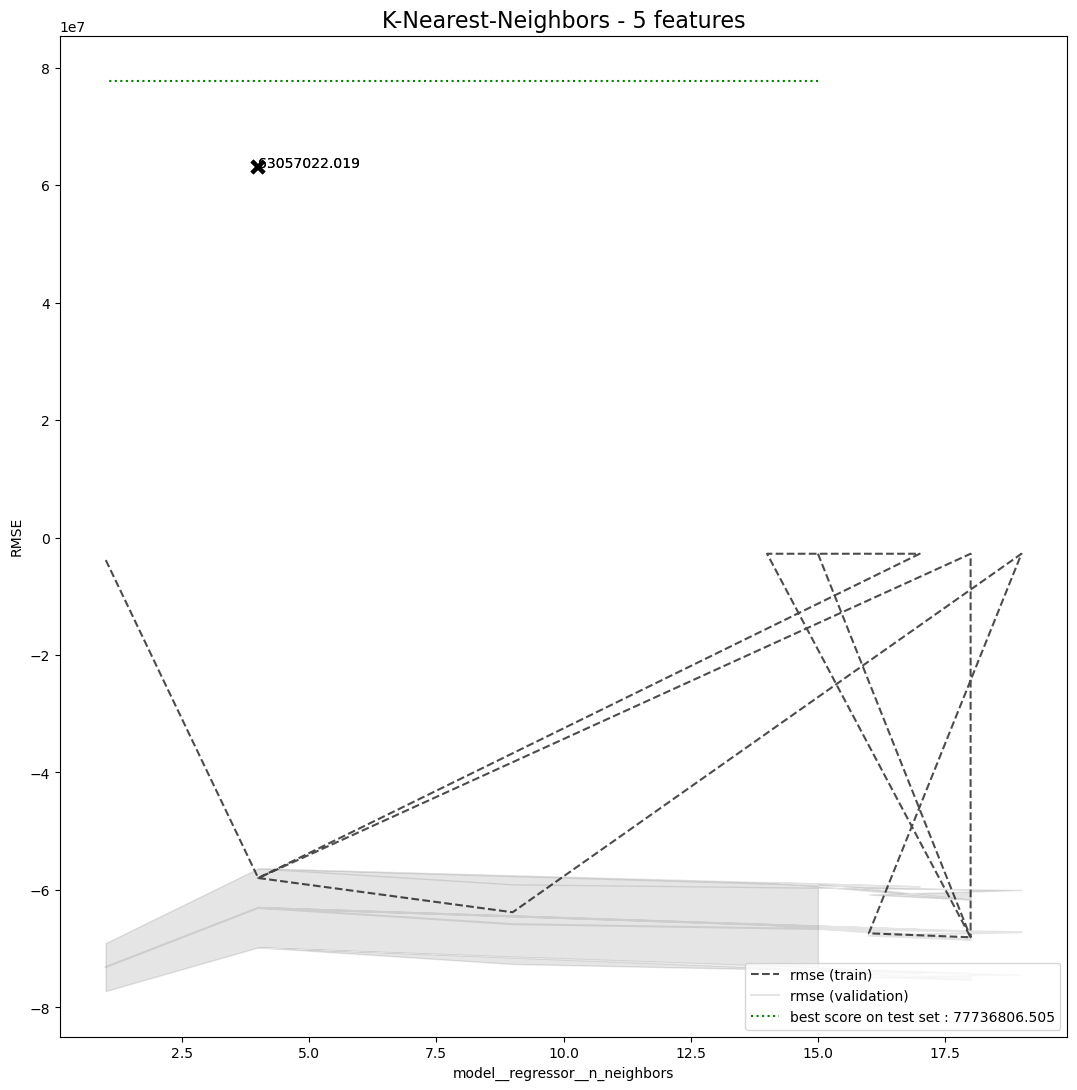

In [28]:
# get the index of the best model 
# among the set of best models found through bayesian search
# for a different number of features
best_model_idx = np.argmin(results["test_scores"])

cv_results = results["cv_results"][best_model_idx]
val_score = results["val_scores"][best_model_idx]
test_score = results["test_scores"][best_model_idx]
best_iter_index = results["best_iter_indexes"][best_model_idx]
best_number_of_features = results["features_kepts"][best_model_idx]

param_name = KNN["validation_param"]

evaluate_model(cv_results, val_score, test_score, best_iter_index, param_name, title=f"{model_name} - {best_number_of_features} features")

### Multi-Layer Perceptron

In [ ]:
MLP_pipe = Pipeline([
	("model", TransformedTargetRegressor(regressor=MLPRegressor(), func=np.log1p, inverse_func=np.expm1))
])

MLP = {
	"instance": MLP_pipe,
	"hyperparameters": {
		"model__regressor__hidden_layer_sizes": [(25,25,25),(25,25),(25,)],
		"model__regressor__activation": ["identity", "logistic", "tanh", "relu"],
		"model__regressor__alpha": 10.0 ** -np.arange(1, 7), # https://scikit-learn.org/stable/modules/neural_networks_supervised.html,
		"model__regressor__max_iter": (10, 10000, "log-uniform")
	},
	"n_iter": 12,
	"validation_param": "model__regressor__hidden_layer_sizes"
}

k_candidates = [5, 10, 15, 20]

estimators = []
scores = []
params = []

for k in k_candidates:
	X_train_filtered, X_test_filtered = select_features_MI_kbest(X_train, y_train, X_test, k=k)

	ms = ModelSelection(
		X_train=X_train_filtered,
		y_train=y_train,
		X_test=X_test_filtered,
		y_test=y_test,
		kf=kf,
		scorer=rmse
	)

	best_estimator, best_params, best_score = ms.test_model(
		model=MLP, 
		name="Multi-Layer Perceptron"
	)

	estimators.append(best_estimator)
	params.append(best_params)
	scores.append(round(best_score, 3))

results = pd.DataFrame({
	"Features kepts [%]": k_candidates,
	"params": params,
	"val scores": scores
})

results

### Random Forest

#### Baseline

In [ ]:
n_fold = 0 
oof_rmse = 0

pred_rf_test = np.zeros(len(X2))

for train_index, val_index in kf.split(X_train, y_train):
    X_train_stra, X_val_stra = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
    y_train_stra, y_val_stra = y_train.iloc[train_index], y_train.iloc[val_index]
    
    print()
    print(f"Fold: {n_fold}")
    print()
    
    # setting up a basic random forest
    random_forest_pipe = Pipeline([
		("model", TransformedTargetRegressor(regressor=RandomForestRegressor(random_state=42, n_estimators=100), func=np.log1p, inverse_func=np.expm1))
	])
    
    # train the model on the stratified k-fold training set
    random_forest_pipe.fit(X_train_stra, y_train_stra)
    
    # predict regression on the whole test set
    pred = random_forest_pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=pred))
    print(f"Fold {n_fold} -- test RMSE: {rmse}")
    
    n_fold += 1
    oof_rmse += rmse
    
    pred_rf_test += random_forest_pipe.predict(X2[X_train.columns]) / N_SPLITS
  
print(f"Out-of-fold RMSE: {oof_rmse / N_SPLITS}")

fig, ax = plt.subplots(2, figsize=(12, 7))
sns.set(rc={"figure.figsize": (9, 14)})

sns.distplot(y_train, ax=ax[0])
sns.distplot(pred_rf_test, ax=ax[1])
fig.tight_layout()

#### Tuning

In [ ]:
random_forest_pipe = Pipeline([
	("model", TransformedTargetRegressor(regressor=RandomForestRegressor(random_state=42), func=np.log1p, inverse_func=np.expm1))
])

rf_bayes = {
	"instance": random_forest_pipe,
	"hyperparameters": {
		"model__regressor__n_estimators": (35, 100),
		"model__regressor__criterion": ["absolute_error"], #["squared_error", "absolute_error", "poisson"],
		"model__regressor__max_depth": (7, 12), #[3, 5, 7, 10, 12, None] # none means unbounded max depth
		"model__regressor__min_samples_split": (2, 20),
    	"model__regressor__min_samples_leaf": (1, 20)
	},
	"n_iter": 12,
	"validation_param": "model__regressor__max_depth"
}

k_candidates = [5, 10, 15, 20]

estimators = []
scores = []
params = []

for k in k_candidates:
	X_train_filtered, X_test_filtered = select_features_MI_kbest(X_train, y_train, X_test, k=k)

	ms = ModelSelection(
		X_train=X_train_filtered,
		y_train=y_train,
		X_test=X_test_filtered,
		y_test=y_test,
		kf=kf,
		scorer=rmse
	)

	best_estimator, best_params, best_score = ms.test_model(
		model=rf_bayes, 
		name="Random Forest"
	)

	estimators.append(best_estimator)
	params.append(best_params)
	scores.append(round(best_score, 3))

results = pd.DataFrame({
	"Features kepts [%]": k_candidates,
	"params": params,
	"val scores": scores
})

results

#### Validation of the best model (overfitting, underfitting)

In [ ]:
# plot validation curve of the best model
best_idx = np.argmin(scores)

best_estimator = estimators[best_idx]
best_number_of_faetures = k_candidates[best_idx]

X_train_filtered, X_test_filtered = select_features_MI_kbest(X_train, y_train, X_test, k=k_candidates[best_idx])

validation_param = rf_bayes["validation_param"]

validate_model(
	model=best_estimator, 
	model_name="Random Forest", 
	param_name=validation_param, 
	param_range=rf_bayes["hyperparameters"][validation_param], 
	X_train=X_train_filtered, 
	y_train=y_train, 
	X_test=X_test_filtered, 
	y_test=y_test, 
	kf=kf, 
	scorer=rmse
)

## Prediction

We're gonna make prediction about the revenue of movies present in `X2.csv`.